# Train U-Net for cervix/os detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from datetime import datetime


# On Colfax :
if os.path.exists("/home/u2459/keras-1.2.2"):
    keras_lib_path = "/home/u2459/keras-1.2.2/build/lib"
    if not keras_lib_path in sys.path:
        sys.path.insert(0, "/home/u2459/keras-1.2.2/build/lib")
    from keras import __version__
    print "Keras version: ", __version__
    import theano
    print "mkl_available: ", theano.sandbox.mkl.mkl_available()

    
# Project
project_common_path = os.path.abspath(os.path.join('..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)    

## Transform `sloth` annotations to label images

In [3]:
from data_utils import type_1_ids, type_2_ids, type_3_ids, test_ids
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations

from image_utils import get_image_data
from image_utils import generate_label_images

In [4]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print(len(annotations))

# generate_label_images(annotations)

639


In [7]:
!ls {GENERATED_DATA}/
!ls {GENERATED_DATA}/trainval_labels | wc -l

labels                            trainval_labels
templates.csv                     unet_os_cervix_detector_stats.npz
     639


## Run on local machine

In [8]:
import numpy as np

from training_utils import get_trainval_id_type_lists2
from test_utils import get_test_id_type_list2

from unet_keras_v1 import get_unet

from training_utils import segmentation_train as train, segmentation_validate as validate
from test_utils import segmentation_predict as predict

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


In [9]:
np.random.seed(2017)

In [10]:
train_id_type_list, val_id_type_list = get_trainval_id_type_lists2(annotations=annotations, val_split=0.25)

print "Total : %s, Train : %s, Val : %s" % (len(annotations), len(train_id_type_list), len(val_id_type_list))

print("\n {} - Get U-Net model ...".format(datetime.now()))
unet = get_unet(input_shape=(3, 224, 224), n_classes=2)

Total : 639, Train : 479, Val : 160

 2017-03-30 08:57:17.290636 - Get U-Net model ...


In [11]:
#unet.summary()

Load trained weights

In [13]:
save_prefix='unet_os_cervix_detector' # + datetime.now().strftime("%Y-%m-%d-%H-%M")

# from glob import glob

# weights_files = glob("weights/%s*.h5" % save_prefix)
# best_val_loss = 1e5
# best_weights_filename = ""
# for f in weights_files:
#     index = os.path.basename(f).index('-')
#     loss = float(os.path.basename(f)[index+1:-4])
#     if best_val_loss > loss:
#         best_val_loss = loss
#         best_weights_filename = f
# print("Best val loss weights: ", best_weights_filename)


# if len(best_weights_filename) > 0:
#     # load weights to the model
#     print("Load found weights: ", best_weights_filename)
#     unet.load_weights(best_weights_filename)

In [ ]:
if True:
    nb_epochs = 50
    batch_size = 4   

    print("\n {} - Start training ...".format(datetime.now()))
    train(unet, train_id_type_list, val_id_type_list, nb_epochs=nb_epochs, batch_size=batch_size, save_prefix=save_prefix)


 2017-03-30 08:57:29.238612 - Start training ...
('Training parameters: ', 4, 50, 1024, 256)
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_stats.npz
No need to recompute statistics


In [9]:
# batch_size = 1
# print("\n {} - Start validation ...".format(datetime.now()))
# validate(unet, val_id_type_list, batch_size=batch_size)

In [10]:
id_type_list = [val_id_type_list[i] for i in [0, 3, 4, 9, 10, 14, 15, 17]]

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

(1, 3, 224, 224) (1, 2, 224, 224) 0.0 1.0 [(u'917', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.89893e-16 1.0 [(u'1452', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 6.33956e-23 1.0 [(u'171', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.91389e-19 1.0 [(u'725', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.74326e-30 1.0 [(u'1457', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 1.22052e-19 1.0 [(u'267', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.01408e-23 1.0 [(u'516', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.41777e-24 1.0 [(u'1198', u'Type_2')]


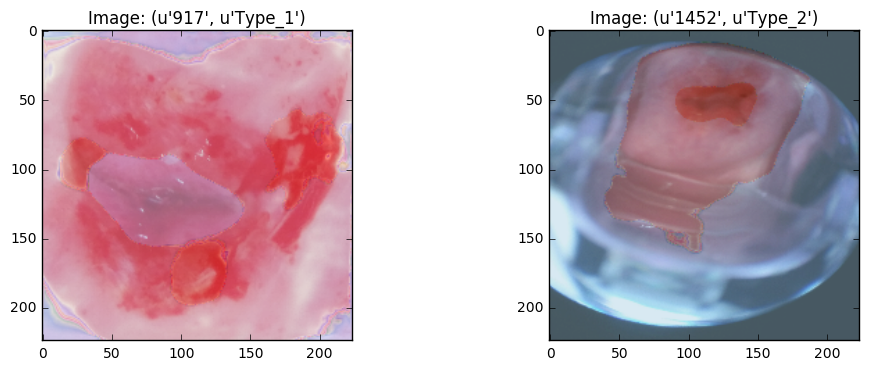

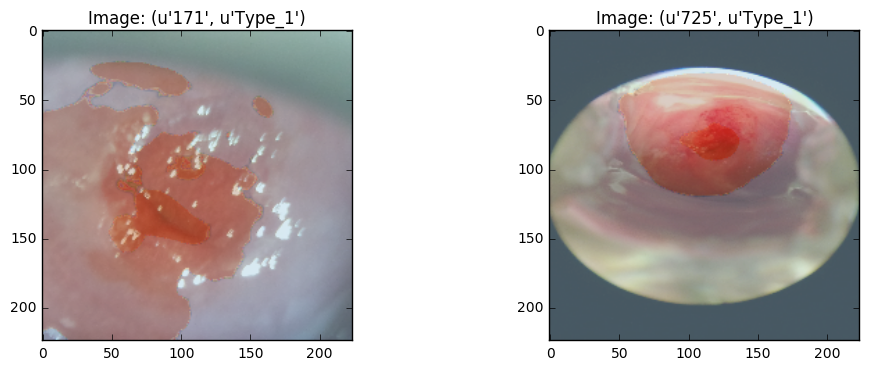

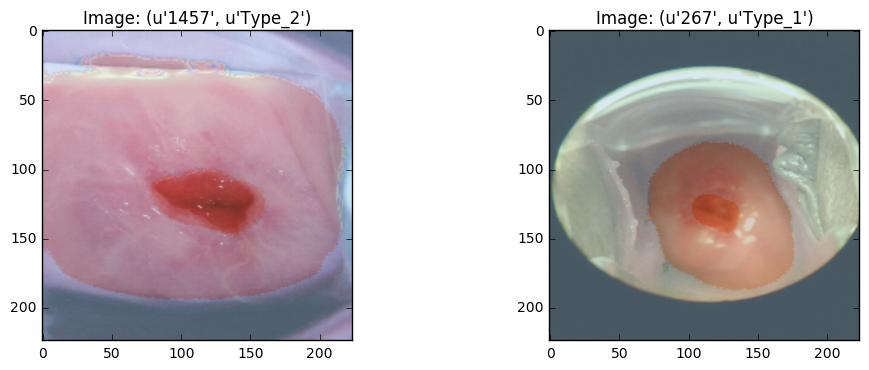

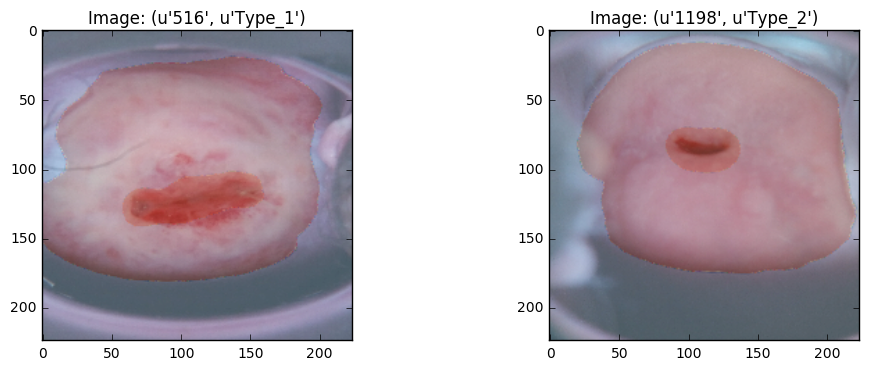

In [13]:
batch_size = 1

from preprocessing.image.iterators import XYIterator
from training_utils import segmentation_xy_provider

train_iter = XYIterator(segmentation_xy_provider(train_id_type_list, test_mode=True), 
                          len(train_id_type_list), 
                          None, # image generator
                          batch_size=batch_size,
                          data_format='channels_first')

max_counter = 8
n = 2   
counter = 0
for x, y_true, info in train_iter:           
    y_pred = unet.predict(x)    
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info, 
    
    if counter % n == 0:
        plt_st(12, 4)
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
    plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
    plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
    plt.title("Image: {}".format(info[0]))
                    
    counter += 1
    if counter == max_counter:
        break

(1, 3, 224, 224) (1, 2, 224, 224) 1.21989e-18 1.0 [(u'1379', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 5.83157e-15 1.0 [(u'1209', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.53947e-23 1.0 [(u'441', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 7.11872e-36 1.0 [(u'148', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.84561e-35 1.0 [(u'802', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.1018e-18 1.0 [(u'906', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 9.8479e-29 1.0 [(u'421', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.36147e-16 1.0 [(u'1436', u'Type_2')]


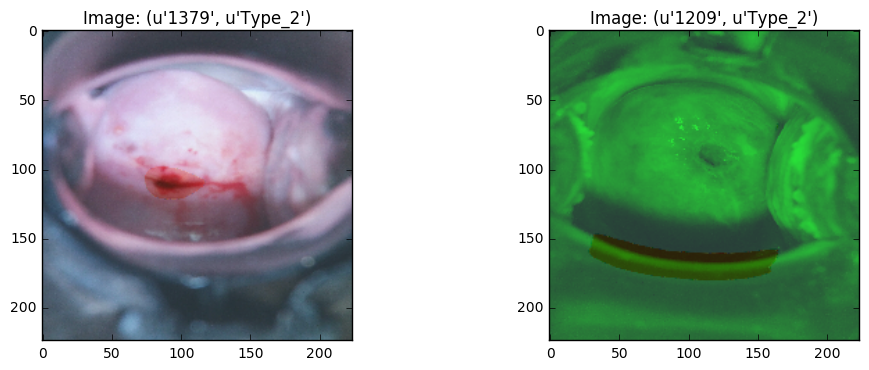

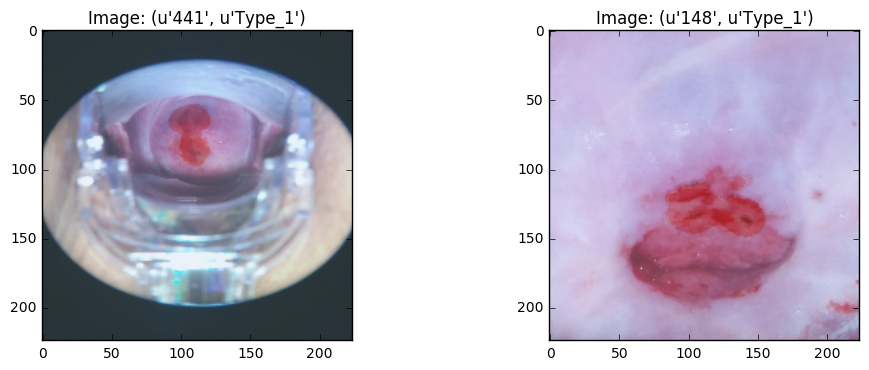

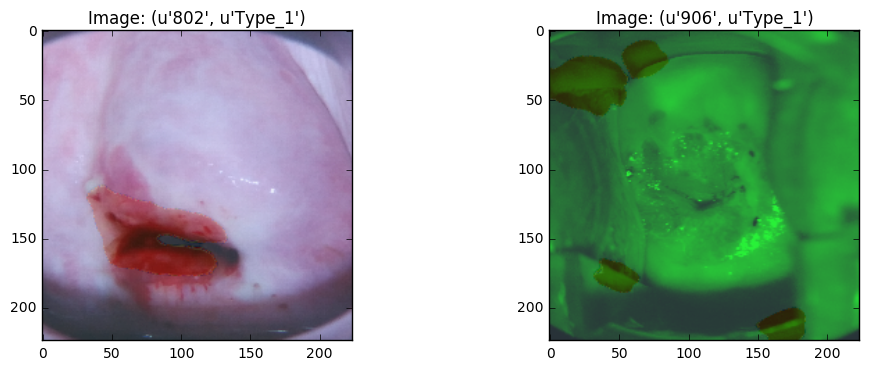

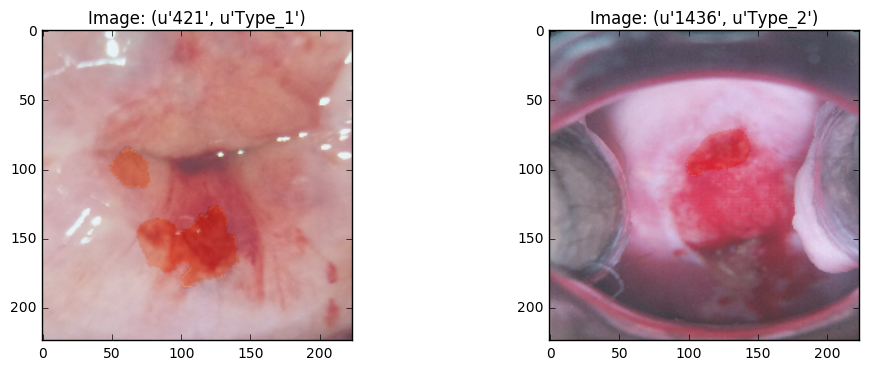

In [12]:
batch_size = 1

from preprocessing.image.iterators import XYIterator
from training_utils import segmentation_xy_provider

val_iter = XYIterator(segmentation_xy_provider(id_type_list, test_mode=True), 
                          len(id_type_list), 
                          None, # image generator
                          batch_size=batch_size,
                          data_format='channels_first')

max_counter = 8
n = 2   
counter = 0
for x, y_true, info in val_iter:           
    y_pred = unet.predict(x)
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info
    
    if counter % n == 0:
        plt_st(12, 4)
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
    plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
    plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
    plt.title("Image: {}".format(info[0]))
                    
    counter += 1
    if counter == max_counter:
        break


In [11]:
test_id_type_list = get_test_id_type_list2(annotations)
len(test_id_type_list)

1785

In [ ]:
batch_size = 2
predict(unet, test_id_type_list, batch_size=batch_size)

## Submit job with `qsub`

In [12]:
from qsub_utils import submit_job
from qsub_utils import setup_configuration
from qsub_utils import PBS_CONFIGURATION

In [14]:
setup_configuration(nodes='2:knl7210:ram96gb')

In [17]:
import time 

unet_cervix_os_detection_with_keras_cmd = [
    "python",
    os.path.abspath(os.path.join("..", "scripts", "unet_cervix_os_detection_with_keras.py"))
]

process, job_info = submit_job(unet_cervix_os_detection_with_keras_cmd, 
                               name='unet_cervix_os_detection', 
                               cwd=RESOURCES_PATH)

try:
    while True:
        out = process.stdout.readline()    
        if len(out) > 0:        
            print out

        if process.poll() is not None and len(out) == 0:
            break
except KeyboardInterrupt:
    !qdel {job_info['id']}
    time.sleep(1.0)
    !qstat

qsub: job 4736.c001 ready





  ########################################################################

  # Colfax Cluster - https://colfaxresearch.com/

  #      Date:           Wed Mar 29 06:55:21 PDT 2017

  #    Job ID:           4736.c001

  #      User:           u2459

  # Resources:           neednodes=2:knl7210:ram96gb,nodes=2:knl7210:ram96gb,walltime=24:00:00

  ########################################################################

  

Using Theano backend.

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.

         It is better to let Theano/g++ find it automatically, but we don't do it now

Keras version:  1.2.2

mkl_available:  True



 2017-03-29 06:55:41.960263 - Get train/val lists ...

Total : 208, Train : 156, Val : 52



 2017-03-29 06:55:42.015378 - Get U-Net model ...



 2017-03-29 06:55:46.961775 - Start validation ...

('--', 4, 'batch jaccard index : ', 0.17125155)

('--', 8, 'batch jaccard index : ', 0.

In [18]:
!qstat

[autoreload of test_utils failed: Traceback (most recent call last):
  File "/opt/intel/intelpython27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name ImageMaskIterator
]


In [11]:
#!{" ".join(unet_cervix_os_detection_with_keras_cmd)}

Using Theano backend.
Couldn't import dot_parser, loading of dot files will not be possible.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 0 failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1

Traceback (most recent call last):
  File "/Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/scripts/unet_cervix_os_detection_with_keras.py", line 8, in <module>
    from keras.callbacks import ModelCheckpoint
  File "/usr/local/lib/python2.7/site-packages/keras/__init__.py", line 2, in <module>
    from . import backend
  File "/usr/local/lib/python2.7/site-packages/keras/backend/__init__.py", line 64, in <module>
    from .theano_back

In [31]:
def foo(*args):
    print "--", args
    out = list(args)
    for i, a in enumerate(args):
        out[i] = np.power(a, 2.0)
    return out

In [32]:
x=1
y=2
z=3

foo(x, y, z)

-- (1, 2, 3)


[2, 3, 4]